In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sci-learn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("CVD_cleaned.csv")

In [4]:
import numpy as np
def randomly_remove_values(dataframe, percentage):
    df_with_nans = df.copy()
    for column in df_with_nans.columns:
        if df_with_nans[column].dtype in [float, int, object]:  
            df_with_nans.loc[df_with_nans.sample(frac=percentage).index, column] = np.nan
    return df_with_nans

#10% of the values
df_missing_10 = randomly_remove_values(df, 0.10)

#20% of the values
#df_missing_20 = randomly_remove_values(df, 0.20)


In [5]:
df_missing_10.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,NaN,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,NaN,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,NaN,No,NaN,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,NaN,NaN,NaN,30.0,8.0
4,Good,Within the past year,No,No,NaN,No,NaN,No,No,Male,80+,191.0,NaN,24.37,Yes,0.0,8.0,4.0,0.0


In [6]:
#Replacing NaN with mean for numerical data
df_filled_mean = df_missing_10.fillna(df_missing_10.mean(numeric_only=True))
#Replacing NaN with mode for categorical data
df_filled_mode = df_missing_10.fillna(df_missing_10.mode().iloc[0])

In [7]:
from sklearn.preprocessing import LabelEncoder

# Stwórz instancję LabelEncoder
label_encoder = LabelEncoder()

# Kodowanie kolumn kategorycznych
df['Sex_Encoded'] = label_encoder.fit_transform(df['Sex'])


health_mapping = {'Excellent': 5,'Very Good':4,'Good': 3, 'Fair': 2, 'Poor': 1}
df['General_Health_Encoded'] = df['General_Health'].map(health_mapping)

In [8]:

columns_to_encode = [
    'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 
    'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 
    'Age_Category', 'Smoking_History'
]

for col in columns_to_encode:
    df[col + '_Encoded'] = label_encoder.fit_transform(df[col])

In [9]:
encoded_columns = [col for col in df.columns if '_Encoded' in col]
numerical_columns = [col for col in df.columns if col + '_Encoded' not in df.columns]
for col in numerical_columns:
    print(col)
df_encoded = df[numerical_columns]

Height_(cm)
Weight_(kg)
BMI
Alcohol_Consumption
Fruit_Consumption
Green_Vegetables_Consumption
FriedPotato_Consumption
Sex_Encoded
General_Health_Encoded
Checkup_Encoded
Exercise_Encoded
Heart_Disease_Encoded
Skin_Cancer_Encoded
Other_Cancer_Encoded
Depression_Encoded
Diabetes_Encoded
Arthritis_Encoded
Age_Category_Encoded
Smoking_History_Encoded


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)


In [11]:
### MODELS, so removing heart_disease_encoded
all_other_labels = [col for col in df_normalized.columns if "Heart_Disease" not in col]
df_whole_train = df_normalized[all_other_labels]
expected = df_normalized['Heart_Disease_Encoded']

In [12]:
important_labels = ['General_Health_Encoded', 'Age_Category_Encoded', 'BMI', 'Diabetes_Encoded']
df_kmeans = df_normalized[important_labels]


In [14]:
### k-MEANS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score, accuracy_score

def evaluate_kmeans(X, truth, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    guess = kmeans.fit_predict(X)
    ari = adjusted_rand_score(truth, guess)

    return ari

for i in range(2, 10):
    print("for K = ", i)
    result = evaluate_kmeans(df_kmeans, expected, i)
    print("ARI = ", result, '\n')


for K =  2
ARI =  0.12970271521135568 

for K =  3
ARI =  0.030461939125581802 

for K =  4
ARI =  0.00986984062016435 

for K =  5
ARI =  0.01597016741641252 

for K =  6
ARI =  0.021454403829777775 

for K =  7
ARI =  0.00587367819347848 

for K =  8
ARI =  0.005636256772380503 

for K =  9
ARI =  0.005767938390531444 



In [ ]:
# DBSCAN
important_labels = ['General_Health_Encoded', 'Age_Category_Encoded', 'Sex_Encoded', 'BMI']
df_dbscan = df_normalized[important_labels].sample(frac=0.25, random_state=42)

sampled = df_normalized.sample(frac=0.25, random_state=42)
df_dbscan = sampled[important_labels]
truth = sampled['Heart_Disease_Encoded']
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score



truth = df_normalized['Heart_Disease_Encoded']

for eps in range(20, 50, 10):    
    dbscan = DBSCAN(eps=eps/10, min_samples=8) 
    
    guess = dbscan.fit_predict(df_dbscan)
    ari = adjusted_rand_score(truth, guess)
    print("ARI: ", ari, ", for eps= ", eps/10)

In [55]:

if len(set(dbscan.labels_)) > 1:  # ARI is not defined if all points are classified as noise
    ari = adjusted_rand_score(df_normalized['Heart_Disease_Encoded'], dbscan.labels_)
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
else:
    print("ARI cannot be computed because DBSCAN labeled all points as noise.")



Adjusted Rand Index (ARI): -0.0154


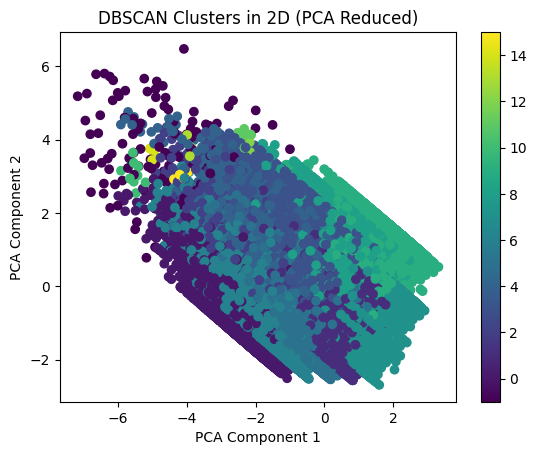

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_2D = pca.fit_transform(scaled_data)

# Visualize the clusters in 2D after PCA reduction
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=dbscan.labels_, cmap='viridis', marker='o')
plt.title('DBSCAN Clusters in 2D (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()